## Data Cleaning and Shape Examining 


## Home Depot Product Search Relevance



Shoppers rely on Home Depot’s product authority to find and buy the latest products and to get timely solutions to their home improvement needs. From installing a new ceiling fan to remodeling an entire kitchen, with the click of a mouse or tap of the screen, customers expect the correct results to their queries – quickly. Speed, accuracy and delivering a frictionless customer experience are essential.

In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.

### Data description

This data set contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.

The relevance is a number between 1 (not relevant) to 3 (highly relevant). For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. There are three additional things to know about the ratings:

The specific instructions given to the raters is provided in relevance_instructions.docx.
Raters did not have access to the attributes.
Raters had access to product images, while the competition does not include images.
Your task is to predict the relevance for each pair listed in the test set. Note that the test set contains both seen and unseen search terms.



### File descriptions

- train.csv - the training set, contains products, searches, and relevance scores
- test.csv - the test set, contains products and searches. You must predict the relevance for these pairs.
- product_descriptions.csv - contains a text description of each product. You may join this table to the training or test set via the product_uid.
- attributes.csv -  provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product will have attributes.
- sample_submission.csv - a file showing the correct submission format
- relevance_instructions.docx - the instructions provided to human raters

### Data fields

- id - a unique Id field which represents a (search_term, product_uid) pair
- product_uid - an id for the products
- product_title - the product title
- product_description - the text description of the product (may contain HTML content)
- search_term - the search query
- relevance - the average of the relevance ratings for a given id
- name - an attribute name
- value - the attribute's value

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

training_data = pd.read_csv("../input/train.csv", encoding="ISO-8859-1")
testing_data = pd.read_csv("../input/test.csv", encoding="ISO-8859-1")
attribute_data = pd.read_csv('../input/attributes.csv')
descriptions = pd.read_csv('../input/product_descriptions.csv')


Let's try to examing the data and try to spot if there are anything suspicious about it

In [6]:
print("training data shape is:",training_data.shape)
print("testing data shape is:",testing_data.shape)
print("attribute data shape is:",attribute_data.shape)
print("description data shape is:",descriptions.shape)

training data shape is: (74067, 5)
testing data shape is: (166693, 4)
attribute data shape is: (2044803, 3)
description data shape is: (124428, 2)


In [7]:
print("training data has empty values:",training_data.isnull().values.any())
print("testing data has empty values:",testing_data.isnull().values.any())
print("attribute data has empty values:",attribute_data.isnull().values.any())
print("description data has empty values:",descriptions.isnull().values.any())

training data has empty values: False
testing data has empty values: False
attribute data has empty values: True
description data has empty values: False


In [8]:
training_data.head(10)

id  product_uid    ...              search_term relevance
0   2       100001    ...            angle bracket      3.00
1   3       100001    ...                l bracket      2.50
2   9       100002    ...                deck over      3.00
3  16       100005    ...         rain shower head      2.33
4  17       100005    ...       shower only faucet      2.67
5  18       100006    ...           convection otr      3.00
6  20       100006    ...     microwave over stove      2.67
7  21       100006    ...               microwaves      3.00
8  23       100007    ...          emergency light      2.67
9  27       100009    ...                  mdf 3/4      3.00

[10 rows x 5 columns]

In [9]:
print("there are in total {} products ".format(len(training_data.product_title.unique())))
print("there are in total {} search query ".format(len(training_data.search_term.unique())))
print("there are in total {} product_uid".format(len(training_data.product_uid.unique())))




there are in total 53489 products 
there are in total 11795 search query 
there are in total 54667 product_uid


In [10]:
testing_data.head(10)

id            ...                            search_term
0   1            ...                      90 degree bracket
1   4            ...                       metal l brackets
2   5            ...                       simpson sku able
3   6            ...                   simpson strong  ties
4   7            ...              simpson strong tie hcc668
5   8            ...                        wood connectors
6  10            ...                    bath and shower kit
7  11            ...                         bath drain kit
8  12            ...                   one piece tub shower
9  13            ...                            solar panel

[10 rows x 4 columns]

In [11]:
print("there are in total {} products ".format(len(testing_data.product_title.unique())))
print("there are in total {} search query ".format(len(testing_data.search_term.unique())))
print("there are in total {} product_uid".format(len(testing_data.product_uid.unique())))





there are in total 94731 products 
there are in total 22427 search query 
there are in total 97460 product_uid


In [12]:
attribute_data.head(10)

product_uid                        ...                                                                      value
0     100001.0                        ...                          Versatile connector for various 90° connection...
1     100001.0                        ...                          Stronger than angled nailing or screw fastenin...
2     100001.0                        ...                          Help ensure joints are consistently straight a...
3     100001.0                        ...                                      Dimensions: 3 in. x 3 in. x 1-1/2 in.
4     100001.0                        ...                                                   Made from 12-Gauge steel
5     100001.0                        ...                                  Galvanized for extra corrosion resistance
6     100001.0                        ...                          Install with 10d common nails or #9 x 1-1/2 in...
7     100001.0                        ...                                                                         12
8     100001.0                        ...                                                           Galvanized Steel
9     100001.0                        ...                                                         Simpson Strong-Tie

[10 rows x 3 columns]

In [13]:
print("there are in total {} product_uid ".format(len(attribute_data.product_uid.unique())))
print("there are in total {} names ".format(len(attribute_data.name.unique())))
print("there are in total {} values".format(len(attribute_data.value.unique())))






there are in total 86264 product_uid 
there are in total 5411 names 
there are in total 307588 values


In [14]:
descriptions.head(10)

product_uid                                product_description
0       100001  Not only do angles make joints stronger, they ...
1       100002  BEHR Premium Textured DECKOVER is an innovativ...
2       100003  Classic architecture meets contemporary design...
3       100004  The Grape Solar 265-Watt Polycrystalline PV So...
4       100005  Update your bathroom with the Delta Vero Singl...
5       100006  Achieving delicious results is almost effortle...
6       100007  The Quantum Adjustable 2-Light LED Black Emerg...
7       100008  The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8       100009  Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9       100010  Valley View Industries Metal Stakes (4-Pack) a...

In [15]:
print("there are in total {} product_uid ".format(len(descriptions.product_uid.unique())))
print("there are in total {} product_descriptions ".format(len(descriptions.product_description.unique())))







there are in total 124428 product_uid 
there are in total 110128 product_descriptions 


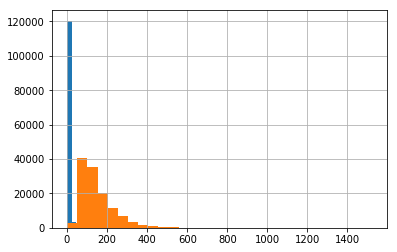

In [16]:
(descriptions.product_description.str.count('\d+') + 1).hist(bins=30)
(descriptions.product_description.str.count('\W')+1).hist(bins=30)




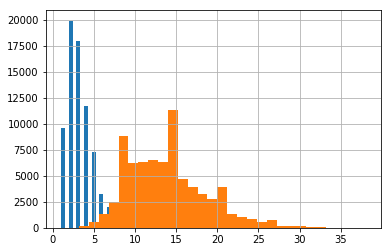

In [17]:
(training_data.product_title.str.count("\\d+") + 1).hist(bins=30)#plot number of digits in title
(training_data.product_title.str.count("\\w+") + 1).hist(bins=30)#plot number of digits in title





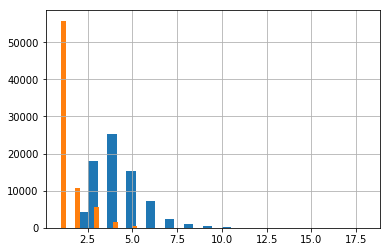

In [18]:
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30) #plot number of words in search therms
(training_data.search_term.str.count("\\d+") + 1).hist(bins=30) #plot number of digits in search terms







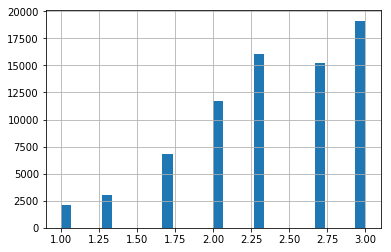

In [19]:
(training_data.relevance ).hist(bins=30)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


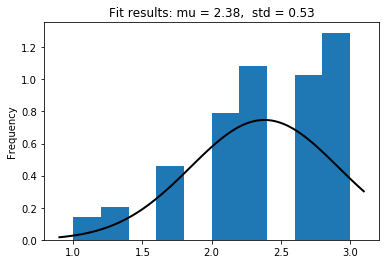

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.relevance.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.relevance)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [21]:
print('total data has html tags in',descriptions.product_description.str.count('<br$').values.sum())

total data has html tags in 173


In [22]:
descriptions[descriptions.product_description.str.contains("<br")].values.tolist()[:3]

[[100050,
  'Sit back and relax in comfort and style in these Beverly Patio Dining Armchairs with Bare Cushions (2-Pack) from Hampton Bay. Perfect for a deck, porch, patio or sunroom, the chairs are made with a powder-coated, sturdy and durable rust-resistant, steel-reinforced frame with all-weather resin wicker to help withstand outdoor elements. Inspired by vintage styles, they feature a woven multi-brown wicker finish and include bare seat cushions that can be customized with slipcovers through the Choose Your Own Color option.Part of the Choose Your Own Color program, slipcovers for cushions must be purchased separatelyAll-weather resin wicker crafts a versatile piece for indoor and outdoor useFashioned with a multi-brown wicker finish for a vintage aesthetic in your outdoor living areaNo assembly requiredAll components packed in 1 boxCoordinates with other brown wicker items in the Beverly collection (sold separately)2-year limited frame, fabric and weave warrantyPowder-coated ste

In [23]:
descriptions.product_description.str.contains("Click here to review our return policy for additional information regarding returns").values.sum()

173

In [24]:
training_data[training_data.search_term.str.contains("^\\d+ . \\d+$")].head(10)

id  product_uid    ...    search_term relevance
3377   10452       101800    ...          4 x 6      2.00
3650   11307       101959    ...          4 x 6      1.67
3766   11705       102041    ...          4 x 6      3.00
4513   14166       102472    ...          4 x 6      1.33
7247   22691       104370    ...        48 x 96      2.33
7485   23405       104575    ...        23 x 38      2.33
13639  42190       110172    ...        20 x 20      2.67
15523  47882       112008    ...        48 x 96      3.00
21335  65959       118174    ...        20 x 20      1.67
23618  72613       120571    ...        20 x 20      1.67

[10 rows x 5 columns]

In [25]:
training_data[training_data.product_uid==100030]

id  product_uid    ...        search_term relevance
44  164       100030    ...     8 4616809045 9      1.67
45  165       100030    ...      shelf bracket      3.00
46  166       100030    ...     white 4shelves      1.67

[3 rows x 5 columns]

from above the following conclusion follows. 
   - At first there exists fields which has html tags in for __description__ dataset. (maybe and error made by the scrapper) along with _Click here to review our return policy_
   - There is no missing/empty values in any of these datasets 
   - in dataset __description__ field product_description contains more digits than word characters
   - some query in dataset __training__ are too straight, it's hard to guess exactly what user meant in terms of broad  sense
   - some of the search query in dataset __training__ has too specific meaning like 8 4616809045 9	
   - number of diggits appearence in the product title tends to be greater number of characters for dataset __training__ (and the same is true for search query field)
   - the relevancy score is between 1 and 3. Because the density of product whose relevancy score is between 2 and 3 is higher we can conclude that most of search query has been classifield between 2 and 3
   - The histogram of relevancy score doesn't follow standard distribution pattern
   
   
   
In order to continue the analysis we will need the whole datasets
   - description datasets might be joined together to training by the product_uid (the same holds for attribute datasets) then clean the html parts
   
   

## Data cleaning

In [26]:
## let's create first the cleaning functions
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter


def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    whole_set = set(str1.split())
#     return sum(int(str2.find(word)>=0) for word in whole_set)
    return np.sum(int(str2.find(word)>=0) for word in whole_set)







In [27]:
############### cleaning html tags ##################
has_tag_in = descriptions.product_description.str.contains('<br')
descriptions.loc[has_tag_in, 'product_description'] = descriptions.loc[has_tag_in, 'product_description'].map(lambda x:remove_html_tag(x))
###############

Examing the search query in the datasets __training__, there some misspelings for field _search_term_ contains a lot of misspelling (more than 3000). This might be fixed by using Google API 

In [28]:
import requests
import re
import time
from random import randint

START_SPELL_CHECK="<span class=\"spell\">Showing results for</span>"
END_SPELL_CHECK="<br><span class=\"spell_orig\">Search instead for"
HTML_Codes = (("'", '&#39;'),('"', '&quot;'),('>', '&gt;'),('<', '&lt;'),('&', '&amp;'))

def spell_check(s):
    q = '+'.join(s.split())
    time.sleep(  randint(0,1) ) #relax and don't let google be angry
    r = requests.get("https://www.google.co.uk/search?q="+q)
    content = r.text
    start=content.find(START_SPELL_CHECK) 
    if ( start > -1 ):
        start = start + len(START_SPELL_CHECK)
        end=content.find(END_SPELL_CHECK)
        search= content[start:end]
        search = re.sub(r'<[^>]+>', '', search)
        for code in HTML_Codes:
            search = search.replace(code[1], code[0])
        search = search[1:]
    else:
        search = s
    return search 

Indeed correcting the misspelings words might help, due to ability of reproducing the result at Kaggle just take it as a spot 

In [29]:
training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")

In [30]:
print("It has blank/empty fields ",training_data.isnull().values.sum())

It has blank/empty fields  0


## Feature Engineering

### Plan
We are going to do the following:
0. Join dataset __training__ with __description__  by  _product uid_ (already done)

2. Create num columns based on text columns
    - count number of words from search query which appears both in product_title and product_description
    - compute edit distnace from search query which appears both in product_title and product_title
    - compute the cosine similarity between search query, product_title and product_description
    - count number of words in the product description
    - create new columns for each pair
    
3. Remove all text columns

As a result we will have vectors of numbers that suites well for the machine learning.

In [31]:
print("has blank/empty values",training_data.isnull().values.any())

has blank/empty values False


In [32]:
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

 
def sentence_similarity(sent1, sent2, stopwords=None):
    sent1 = sent1.split(' ')
    sent2 = sent2.split(' ')
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

# def sentence_similarity(*strs, stopwords = None):
#     text = [t for t in strs]
#     vectorizer = CountVectorizer(text, stop_words=stopwords) if stopwords else CountVectorizer(text)
#     vectorizer.fit(text)
#     r = vectorizer.transform(text).toarray()
#     return 1 - cosine_distance(*r)


def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [33]:
############## apply stemming #####################
training_data['search_term'] = training_data['search_term'].map(lambda x:str_stemmer_title(x))
training_data['product_title'] = training_data['product_title'].map(lambda x:str_stemmer(x))

training_data['product_description'] = training_data['product_description'].map(lambda x:str_stemmer(x))

In [34]:
############## building custome feature, let's build a few of them before compare which one is the best ###########
training_data['shared_words'] = training_data[['search_term','product_description', 'product_title']].apply(lambda row:np.sum([str_common_word(*row[:-1]), str_common_word(*row[1:])]), axis=1)
training_data["edistance_sprot"] = training_data.loc[:, ["search_term","product_title"]].apply(lambda x: edit_distance(*x), axis=1)
training_data["edistance_sd"] = training_data.loc[:, ["search_term","product_description"]].apply(lambda x: edit_distance(*x), axis=1)

training_data['cos_dis_sqt'] = training_data.loc[:, ["search_term","product_title"]].apply(lambda x: sentence_similarity(x[0],x[1]), axis=1)
training_data['cos_dis_sqd'] = training_data.loc[:, ["search_term","product_description"]].apply(lambda x: sentence_similarity(x[0],x[1]),axis=1)

training_data['j_dis_sqt'] = training_data.loc[:, ["search_term","product_title"]].apply(lambda x: get_jaccard_sim(x[0],x[1]), axis=1)
training_data['j_dis_sqd'] = training_data.loc[:, ["search_term","product_description"]].apply(lambda x: get_jaccard_sim(x[0],x[1]),axis=1)



training_data['search_query_length'] = training_data.search_term.str.len()
training_data['number_of_words_in_descr'] = training_data.product_description.str.count("\\w+")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [35]:
training_data.corr()

id            ...             number_of_words_in_descr
id                        1.000000            ...                            -0.067528
product_uid               0.986738            ...                            -0.062033
relevance                -0.116426            ...                             0.040146
shared_words             -0.036805            ...                             0.339178
edistance_sprot           0.044136            ...                             0.317115
edistance_sd             -0.070418            ...                             0.993666
cos_dis_sqt               0.059717            ...                            -0.022591
cos_dis_sqd              -0.022325            ...                             0.005794
j_dis_sqt                 0.016416            ...                             0.026268
j_dis_sqd                 0.041612            ...                            -0.232162
search_query_length       0.193555            ...                             0.086490
number_of_words_in_descr -0.067528            ...                             1.000000

[12 rows x 12 columns]

__test dataset__
we have to have to apply symmetric transformation for both data set, except relevance score field since it is target field. Except we are not allow to take any actions which might lead to overfitting the data

In [36]:
testing_data = pd.merge(testing_data, descriptions, 
                         on="product_uid", how="left")
print("has blank/empty values",testing_data.isnull().values.any())

has blank/empty values False


In [37]:
############## apply stemming for test data #####################
testing_data['search_term'] = testing_data['search_term'].map(lambda x:str_stemmer_title(x))
testing_data['product_title'] = testing_data['product_title'].map(lambda x:str_stemmer(x))

testing_data['product_description'] = testing_data['product_description'].map(lambda x:str_stemmer(x))

############## end stemming #####################

In [38]:
############## building custome feature for test data, let's build a few of them before compare which one is the best ###########
testing_data['shared_words'] = testing_data[['search_term','product_description', 'product_title']].apply(lambda row:np.sum([str_common_word(*row[:-1]), str_common_word(*row[1:])]), axis=1)
testing_data["edistance_sprot"] = testing_data.loc[:, ["search_term","product_title"]].apply(lambda x: edit_distance(*x), axis=1)
testing_data["edistance_sd"] = testing_data.loc[:, ["search_term","product_description"]].apply(lambda x: edit_distance(*x), axis=1)

testing_data['cos_dis_sqt'] = testing_data.loc[:, ["search_term","product_title"]].apply(lambda x: sentence_similarity(x[0],x[1]), axis=1)
testing_data['cos_dis_sqd'] = testing_data.loc[:, ["search_term","product_description"]].apply(lambda x: sentence_similarity(x[0],x[1]),axis=1)

testing_data['j_dis_sqt'] = testing_data.loc[:, ["search_term","product_title"]].apply(lambda x: get_jaccard_sim(x[0],x[1]), axis=1)
testing_data['j_dis_sqd'] = testing_data.loc[:, ["search_term","product_description"]].apply(lambda x: get_jaccard_sim(x[0],x[1]),axis=1)



testing_data['search_query_length'] = testing_data.search_term.str.len()
testing_data['number_of_words_in_descr'] = testing_data.product_description.str.count("\\w+")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [39]:
testing_data.corr()

id            ...             number_of_words_in_descr
id                        1.000000            ...                            -0.090693
product_uid               0.984240            ...                            -0.086780
shared_words             -0.080234            ...                             0.344287
edistance_sprot           0.015366            ...                             0.324202
edistance_sd             -0.092194            ...                             0.993470
cos_dis_sqt               0.094170            ...                            -0.005905
cos_dis_sqd               0.004137            ...                             0.018243
j_dis_sqt                 0.010823            ...                             0.004197
j_dis_sqd                 0.044988            ...                            -0.227508
search_query_length       0.064054            ...                             0.101727
number_of_words_in_descr -0.090693            ...                             1.000000

[11 rows x 11 columns]

In [40]:
training_data.describe()

id            ...             number_of_words_in_descr
count   74067.000000            ...                         74067.000000
mean   112385.709223            ...                            86.955189
std     64016.573650            ...                            49.639511
min         2.000000            ...                            16.000000
25%     57163.500000            ...                            52.000000
50%    113228.000000            ...                            74.000000
75%    168275.500000            ...                           108.000000
max    221473.000000            ...                           574.000000

[8 rows x 12 columns]

In [41]:
testing_data.describe()

id            ...             number_of_words_in_descr
count  166693.000000            ...                        166693.000000
mean   123932.839741            ...                            87.198821
std     71518.389174            ...                            49.287839
min         1.000000            ...                             1.000000
25%     61669.000000            ...                            52.000000
50%    124004.000000            ...                            74.000000
75%    187036.000000            ...                           109.000000
max    240760.000000            ...                           565.000000

[8 rows x 11 columns]

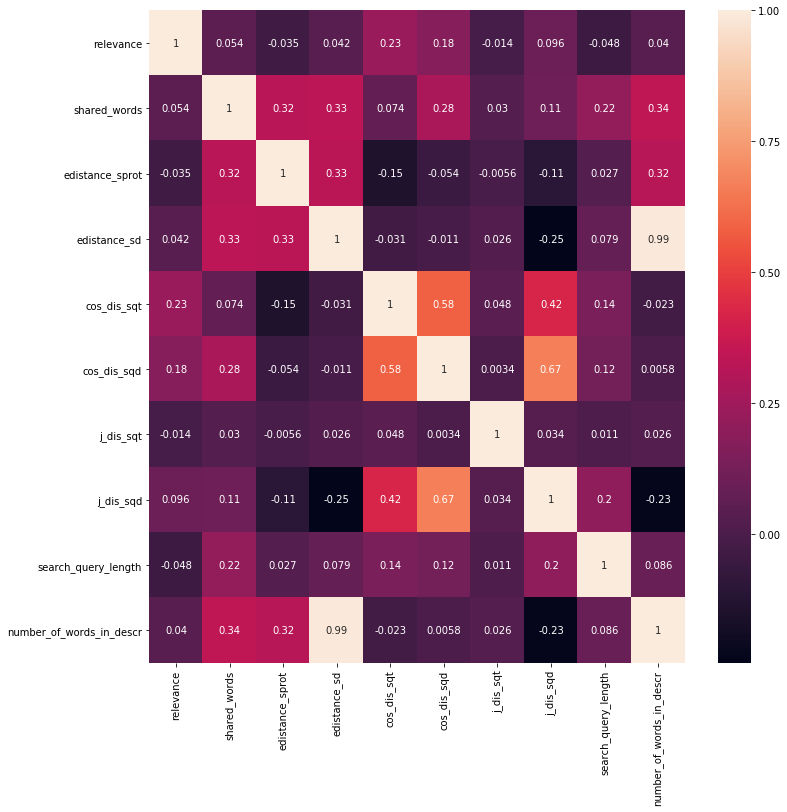

In [42]:
import seaborn as sns
plt.figure(figsize=(12, 12))
temp = training_data.drop(['product_uid','id'],axis=1)
sns.heatmap(temp.corr(), annot=True)
plt.show()

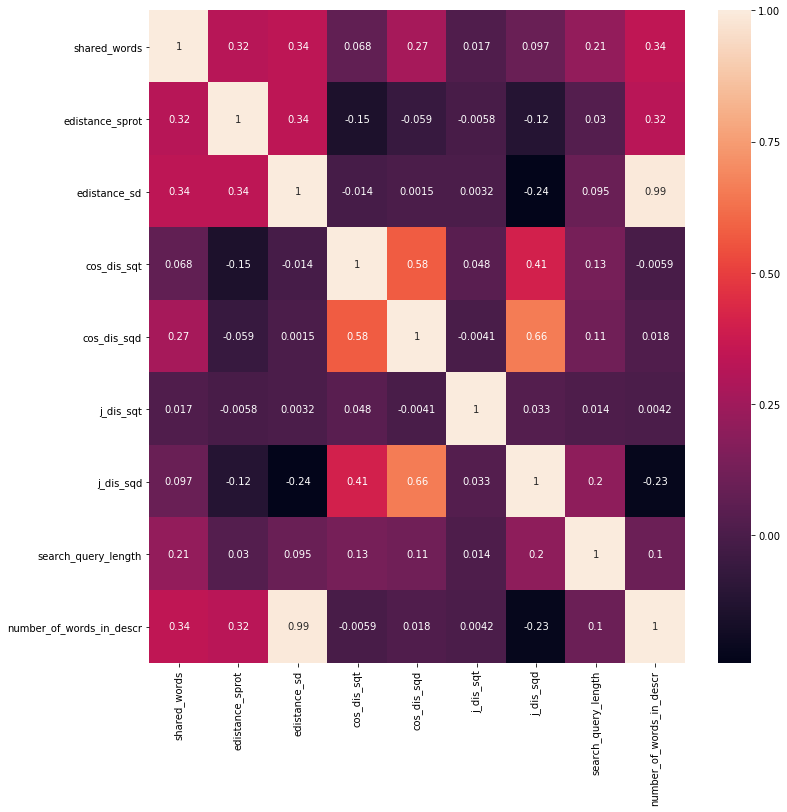

In [43]:
import seaborn as sns
plt.figure(figsize=(12, 12))
temp = testing_data.drop(['product_uid','id'],axis=1)
sns.heatmap(temp.corr(), annot=True)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


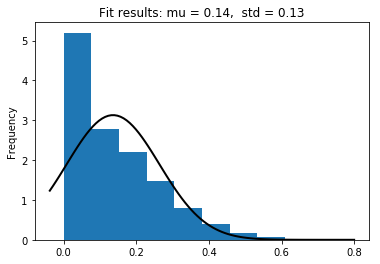

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.cos_dis_sqd.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.cos_dis_sqd)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


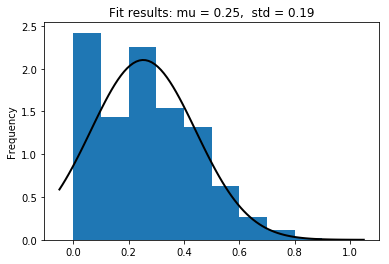

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.cos_dis_sqt.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.cos_dis_sqt)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

From the below histogram we can conclude that the sum of shared words between search_query product_title, and product description follows the standard distribution.


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


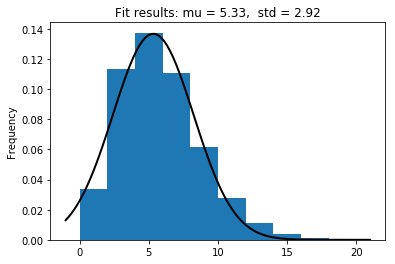

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.shared_words.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.shared_words)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


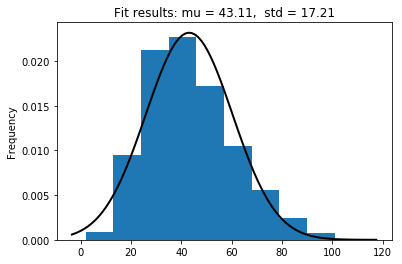

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.edistance_sprot.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.edistance_sprot)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


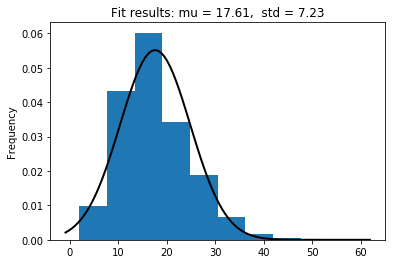

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.search_query_length.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.search_query_length)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

let's examing if the same behaviour can be spotted on __testing__ dataset

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


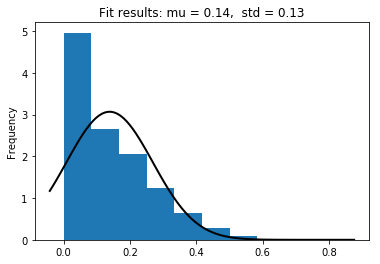

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.cos_dis_sqd.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.cos_dis_sqd)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


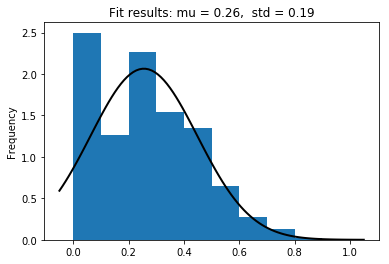

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.cos_dis_sqt.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.cos_dis_sqt)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


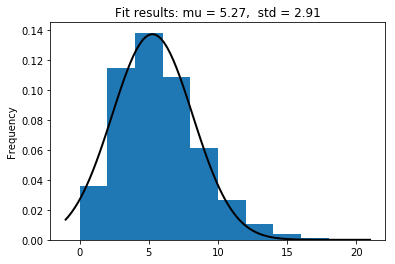

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.shared_words.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.shared_words)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


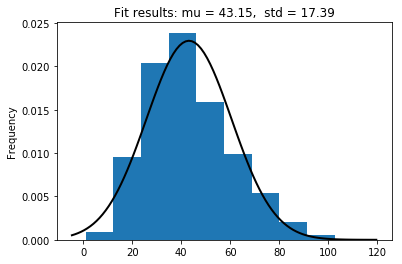

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.edistance_sprot.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.edistance_sprot)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


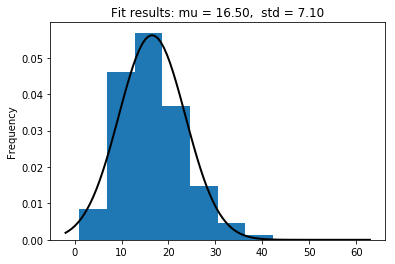

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.search_query_length.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.search_query_length)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

# 3. Let's start machine learning
first of all let's create training and test data sets


We are going to apply the following models:
1. RandomForestRegressor
2. LinearRegression
4. GradientBoostingRegressor 
5. BaggingRegressor
6. XGBoost
7. CatBoost
8. Naive Baies
8. PolynomialFeatures for all previous algorithms


### Plan
We are going to do the following:
0. Define pipeline
1. drop non numeric columns because these information has been already transformed to numberic
2. Apply the model which has been mentioned above within pipeline mode
3. Train models and compare their result on __test__ dataset
4. write a summary about it



In [54]:
df_training = training_data.drop(['product_title','search_term','product_description'],axis=1)

y_train = df_training['relevance'].values
X_train = df_training.drop(['id','relevance'],axis=1).values

In [55]:
testing_data.head(10)

id            ...             number_of_words_in_descr
0   1            ...                                   74
1   4            ...                                   74
2   5            ...                                   74
3   6            ...                                   74
4   7            ...                                   74
5   8            ...                                   74
6  10            ...                                   66
7  11            ...                                   66
8  12            ...                                   66
9  13            ...                                   82

[10 rows x 14 columns]

In [56]:
X_test = testing_data.drop(['id','product_title','search_term','product_description'],axis=1).values
id_test = testing_data['id']


In [61]:
# define models which will be chained togher in a bigger model, which aims to predict the relevancy score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#define standard scaler
scaler = StandardScaler()
scaler.fit(X_train, y_train)
scaled_train_data = scaler.transform(X_train)
scaled_test_data = scaler.transform(X_test)


rf = RandomForestRegressor(n_estimators=4, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=4, max_samples=0.1, random_state=25)


pipeline = Pipeline(steps = [('scaling', scaler), ('baggingregressor', clf)])
#end pipeline 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)


In [64]:
# pipeline.predict(X_test)
y_pred = pipeline.predict(X_test)
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

# Results



|Regressor|Train|Kaggle
|:----------------------|----------|----------|
|CatBoostRegressor|-|-|
|XGBRegressor|-|-|
|GradientBoostingRegressor|-|-|
|PolynomialFeatures on GradientBoostingRegressor|-|-|
|PolynomialFeatures on XGBRegressor|-|-|
|PolynomialFeatures on LinearRegression|-|-|
|PolynomialFeatures on BaggingRegressor on RandomForestRegressor|-|-|
|BaggingRegressor on RandomForestRegressor|0.50735|0.50802|
|Chaining toghether using Pipeline|0.53063|0.53100|
|BayesianRidge|-|-|
|LinearRegression|-|-|
|PolynomialFeatures on BayesianRidge|-|-|
|RandomForestRegressor|-|-|


In [65]:
!cat submission.csv

id,relevance
1,2.2843341585497834
4,2.2843341585497834
5,2.2660543000485793
6,2.2660543000485793
7,2.3236365626999502
8,2.2843341585497834
10,2.334805884422465
11,2.334805884422465
12,2.2843341585497834
13,2.535984194250494
14,2.4123711589047767
15,2.6453989956376316
19,2.2843341585497834
22,2.2843341585497834
24,2.2843341585497834
25,2.2843341585497834
26,2.2843341585497834
28,2.2843341585497834
29,2.2843341585497834
30,2.2843341585497834
31,2.251903794325869
32,2.2843341585497834
33,2.2843341585497834
36,2.2843341585497834
39,2.2843341585497834
40,2.464672956290089
41,2.2843341585497834
42,2.2843341585497834
43,2.248683116883117
44,2.3098691351334613
45,2.5752493101652805
46,2.3604266338915596
47,2.2843341585497834
49,2.2843341585497834
50,2.2843341585497834
52,2.2843341585497834
53,2.2843341585497834
54,2.2843341585497834
55,2.2843341585497834
56,2.2843341585497834
57,2.2843341585497834
58,2.2843341585497834
59,2.2843341585497834
60,2.2843341585497834
61,2.3505448050295854
62,2.2843

28257,2.108360324109399
28261,2.57274162225478
28262,2.2843341585497834
28263,2.2843341585497834
28265,2.2843341585497834
28266,2.4123711589047767
28267,2.4123711589047767
28268,2.2843341585497834
28269,2.2843341585497834
28270,2.440496158904777
28271,2.440496158904777
28272,2.3236365626999502
28273,2.2843341585497834
28274,2.2843341585497834
28275,2.2843341585497834
28277,2.4123711589047767
28278,2.2843341585497834
28281,2.4123711589047767
28284,2.4123711589047767
28285,2.4123711589047767
28291,2.2843341585497834
28293,2.4123711589047767
28295,2.2843341585497834
28297,2.6453989956376316
28298,2.4123711589047767
28299,2.4123711589047767
28300,2.2843341585497834
28301,2.4123711589047767
28302,2.4123711589047767
28303,2.4123711589047767
28305,2.632674729927249
28306,2.632674729927249
28308,2.4123711589047767
28309,2.3604266338915596
28314,2.4131241559808
28315,2.2843341585497834
28316,2.2843341585497834
28317,2.3505448050295854
28318,2.2843341585497834
28319,2.2843341585497834
28322,2.26

55512,2.2843341585497834
55515,2.3256278238230816
55516,2.0802353241093994
55517,2.2843341585497834
55519,2.2843341585497834
55520,2.2843341585497834
55521,2.2843341585497834
55522,2.2843341585497834
55523,2.2843341585497834
55524,2.3236365626999502
55525,2.2843341585497834
55526,2.2843341585497834
55528,2.2843341585497834
55529,2.632674729927249
55532,2.2843341585497834
55533,2.19979439642352
55534,2.2843341585497834
55535,2.6453989956376316
55538,2.2843341585497834
55539,2.3317530216200906
55541,2.313811948148963
55542,2.6453989956376316
55543,2.507619171415484
55546,2.2843341585497834
55547,2.6453989956376316
55548,2.2843341585497834
55549,2.2843341585497834
55551,2.2843341585497834
55552,2.2843341585497834
55554,2.2843341585497834
55555,2.2843341585497834
55557,2.2843341585497834
55558,2.2843341585497834
55559,2.2843341585497834
55561,2.2843341585497834
55562,2.549917973140927
55563,2.6453989956376316
55566,2.2843341585497834
55567,2.2843341585497834
55568,2.2843341585497834
55570,

82521,2.3236365626999502
82524,2.2843341585497834
82525,2.2843341585497834
82526,2.2843341585497834
82527,2.2843341585497834
82528,2.2843341585497834
82529,2.2843341585497834
82533,2.2843341585497834
82534,2.2843341585497834
82535,2.2843341585497834
82536,2.2843341585497834
82537,2.507619171415484
82538,2.2843341585497834
82539,2.2843341585497834
82540,2.632674729927249
82542,2.3256278238230816
82544,2.2843341585497834
82545,2.2843341585497834
82547,2.2843341585497834
82548,2.2843341585497834
82549,2.2843341585497834
82550,2.4123711589047767
82551,2.2843341585497834
82553,2.2843341585497834
82554,2.2843341585497834
82555,2.2843341585497834
82556,2.3709727629049806
82560,2.2843341585497834
82563,2.334805884422465
82564,2.2843341585497834
82565,2.2843341585497834
82566,2.3236365626999502
82567,2.2843341585497834
82568,2.0802353241093994
82571,2.1412598856160474
82572,2.4123711589047767
82574,2.632674729927249
82578,2.403879748086063
82579,2.4123711589047767
82580,2.251903794325869
82581,

109324,2.6453989956376316
109326,2.2843341585497834
109327,2.4123711589047767
109328,2.2843341585497834
109329,2.2843341585497834
109330,2.2843341585497834
109331,2.3654635185384265
109333,2.632674729927249
109334,2.4123711589047767
109335,2.2843341585497834
109336,2.632674729927249
109338,2.2843341585497834
109339,2.3709727629049806
109340,2.2843341585497834
109342,2.2843341585497834
109346,2.3709727629049806
109348,2.2843341585497834
109351,2.2843341585497834
109353,2.264916847262816
109354,2.2843341585497834
109356,2.4123711589047767
109357,2.4123711589047767
109362,2.632674729927249
109363,2.2843341585497834
109366,2.2843341585497834
109369,2.334805884422465
109371,2.4123711589047767
109372,2.3709727629049806
109374,2.2843341585497834
109375,2.2843341585497834
109376,2.632674729927249
109377,2.2843341585497834
109378,2.632674729927249
109379,2.313811948148963
109380,2.334805884422465
109381,2.2843341585497834
109383,2.2843341585497834
109384,2.2843341585497834
109386,2.284334158549

134977,2.2843341585497834
134981,2.4123711589047767
134982,2.4123711589047767
134983,2.2843341585497834
134985,2.2843341585497834
134986,2.2843341585497834
134988,2.1412598856160474
134989,2.4123711589047767
134990,2.2843341585497834
134991,2.2843341585497834
134992,2.2843341585497834
134993,2.4123711589047767
134998,2.2843341585497834
135000,2.3236365626999502
135001,2.0802353241093994
135002,2.4123711589047767
135003,2.2843341585497834
135005,2.338543920124356
135008,2.2843341585497834
135009,2.2843341585497834
135011,2.2843341585497834
135012,2.2843341585497834
135013,2.2843341585497834
135014,2.2843341585497834
135015,2.2843341585497834
135016,2.2843341585497834
135017,2.2843341585497834
135018,2.2843341585497834
135019,2.2843341585497834
135020,2.549917973140927
135021,2.507619171415484
135023,2.256611575326861
135024,2.2843341585497834
135026,2.4123711589047767
135027,2.403879748086063
135030,2.632674729927249
135031,2.3194669105089796
135033,2.4123711589047767
135037,2.284334158

160908,2.632674729927249
160910,2.4123711589047767
160912,2.2843341585497834
160913,2.251903794325869
160914,2.3194669105089796
160916,2.2843341585497834
160921,2.2843341585497834
160924,2.5125582907638777
160925,2.1412129261403163
160927,2.3654635185384265
160929,2.2843341585497834
160931,2.4123711589047767
160932,2.4123711589047767
160934,2.251903794325869
160935,2.4123711589047767
160936,2.4123711589047767
160937,2.2843341585497834
160938,2.2843341585497834
160941,2.2843341585497834
160943,2.2843341585497834
160945,2.2843341585497834
160947,2.2843341585497834
160948,2.4123711589047767
160949,2.3236365626999502
160950,2.632674729927249
160954,2.2843341585497834
160959,2.2843341585497834
160960,2.2843341585497834
160961,2.251903794325869
160963,2.2843341585497834
160965,2.2843341585497834
160966,2.2843341585497834
160967,2.4123711589047767
160968,2.2660543000485793
160971,2.4123711589047767
160972,2.3256278238230816
160973,2.2843341585497834
160974,2.2843341585497834
160975,2.28433415

186980,2.2843341585497834
186984,2.2843341585497834
186985,2.361430233159135
186986,2.2843341585497834
186987,2.2843341585497834
186989,2.2843341585497834
186990,2.2713562939664502
186992,2.403879748086063
186994,2.2843341585497834
186996,2.2843341585497834
186998,2.2843341585497834
186999,2.2843341585497834
187001,2.2843341585497834
187003,2.2843341585497834
187004,2.313811948148963
187006,2.4123711589047767
187007,2.2843341585497834
187008,2.3256278238230816
187009,2.6453989956376316
187011,2.3236365626999502
187012,2.2843341585497834
187013,2.2843341585497834
187014,2.4123711589047767
187017,2.2843341585497834
187019,2.3980332236037514
187020,2.3654635185384265
187022,2.439680473140927
187023,2.2843341585497834
187024,2.4123711589047767
187026,2.2843341585497834
187027,2.2843341585497834
187031,2.4123711589047767
187033,2.2843341585497834
187034,2.2843341585497834
187035,2.2843341585497834
187036,2.2843341585497834
187037,2.4123711589047767
187038,2.3236365626999502
187039,2.3473411

213665,2.3709727629049806
213666,2.632674729927249
213667,2.2843341585497834
213669,2.2843341585497834
213671,2.3194669105089796
213672,2.2843341585497834
213673,2.2843341585497834
213674,2.2843341585497834
213675,2.2843341585497834
213677,2.632674729927249
213678,2.4123711589047767
213679,2.6453989956376316
213681,2.334805884422465
213682,2.2843341585497834
213683,2.2843341585497834
213688,2.2843341585497834
213690,2.3236365626999502
213691,2.2843341585497834
213692,2.248683116883117
213694,2.2843341585497834
213696,2.2843341585497834
213697,2.3604266338915596
213698,2.2843341585497834
213700,2.4123711589047767
213701,2.2843341585497834
213702,2.2843341585497834
213704,2.632674729927249
213705,2.3194669105089796
213706,2.3709727629049806
213707,2.403879748086063
213711,2.2843341585497834
213712,2.2843341585497834
213713,2.1412129261403163
213715,2.3032601686507936
213716,2.2630860696041504
213717,2.3584838791051927
213719,2.549917973140927
213721,2.2843341585497834
213722,2.2843341585

233239,2.6453989956376316
233240,2.632674729927249
233241,2.2843341585497834
233242,2.632674729927249
233243,2.3350550258621126
233244,2.2843341585497834
233245,2.2843341585497834
233246,2.2660543000485793
233247,2.2846955373302498
233248,2.2843341585497834
233249,2.4123711589047767
233250,2.4123711589047767
233251,2.6453989956376316
233252,2.6453989956376316
233253,2.632674729927249
233254,2.2843341585497834
233255,2.2843341585497834
233256,2.2843341585497834
233257,2.334805884422465
233258,2.2843341585497834
233259,2.4123711589047767
233260,2.632674729927249
233261,2.632674729927249
233262,2.2843341585497834
233263,2.334805884422465
233264,2.632674729927249
233265,2.3256278238230816
233266,2.3236365626999502
233267,2.2843341585497834
233268,2.4947139927477617
233269,2.2843341585497834
233270,2.2843341585497834
233271,2.2843341585497834
233272,2.2843341585497834
233273,2.5935285712496197
233274,2.334805884422465
233275,2.2843341585497834
233276,2.2843341585497834
233277,2.284334158549